In [2]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, mean_absolute_error
from random import shuffle
from scipy.io import loadmat
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# 2. DeepSets

In [4]:
def create_train_dataset():
    n_train = 100000
    max_train_card = 10

    ############## Task 1

    ##################
    X_train = np.random.randint(1,max_train_card,(n_train,max_train_card))
    for i in range(n_train):
      erase = np.random.randint(max_train_card)
      X_train[i,:erase] = 0

    y_train = np.sum(X_train,axis=1)
    ##################

    return X_train, y_train


def create_test_dataset():

    ############## Task 2

    ##################
    #X_test = np.zeros((20000,100))
    X_test = []
    y_test = []
    max_train_card = 10
    test_size = 10000
    n_test = 200000
    first_digits = 5
    step_digits = 5
    last_digits = 100
    for digits in range(first_digits, last_digits+1, step_digits):
      #next_X = np.concatenate((np.zeros((10000,last_digits-digits)),np.random.randint(1,max_train_card,(10000,digits))),axis=1)
      #if digits == first_digits:
      #  X_test = next_X
      #else:
      #  X_test = np.concatenate((X_test, next_X),axis=0)
      X_test.append(np.random.randint(1,max_train_card,(10000,digits)))
      y_test.append(np.sum(X_test[-1],axis=1))


    #y_test = np.sum(X_test,axis=1)


    ##################

    return X_test, y_test

In [5]:
class DeepSets(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(DeepSets, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):

        ############## Task 3

        ##################
        x = self.embedding(x)
        x = torch.sum(self.tanh(self.fc1(x)),axis=1)
        x = self.fc2(x)
        ##################

        return x.squeeze()




In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        ############## Task 4

        ##################
        x = self.embedding(x)
        output, (x, c) = self.lstm(x)
        x = self.fc(x)
        ##################

        return x.squeeze()



In [19]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 20
batch_size = 64
embedding_dim = 128
hidden_dim = 64
learning_rate = 0.001

# Generates training data
X_train, y_train = create_train_dataset()
n_train = 100000
n_digits = 11

# Initializes DeepSets model and optimizer
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(deepsets.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the DeepSets model
for epoch in range(epochs):
    t = time.time()
    deepsets.train()

    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):

        ############## Task 5

        ##################
        x_batch = torch.LongTensor(X_train[idx[i:min(i+batch_size, n_train)]])
        y_batch = torch.Tensor(y_train[idx[i:min(i+batch_size, n_train)]])
        ##################

        optimizer.zero_grad()
        output = deepsets(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores DeepSets model into disk
torch.save({
    'state_dict': deepsets.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_deepsets.pth.tar')

print("Finished training for DeepSets model")
print()

# Initializes LSTM model and optimizer
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
loss_function = nn.L1Loss()

# Trains the LSTM model
for epoch in range(epochs):
    t = time.time()
    lstm.train()

    train_loss = 0
    count = 0
    idx = np.random.permutation(n_train)
    for i in range(0, n_train, batch_size):

        ############## Task 5

        ##################
        x_batch = torch.LongTensor(X_train[idx[i:min(i+batch_size, n_train)]])
        y_batch = torch.Tensor(y_train[idx[i:min(i+batch_size, n_train)]])
        ##################

        optimizer.zero_grad()
        output = lstm(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * output.size(0)
        count += output.size(0)

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(train_loss / count),
          'time: {:.4f}s'.format(time.time() - t))

# Stores LSTM model into disk
torch.save({
    'state_dict': lstm.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, 'model_lstm.pth.tar')

print("Finished training for LSTM model")

Epoch: 0001 loss_train: 0.8409 time: 4.6352s
Epoch: 0002 loss_train: 0.0640 time: 6.3065s
Epoch: 0003 loss_train: 0.0491 time: 4.3240s
Epoch: 0004 loss_train: 0.0405 time: 4.2156s
Epoch: 0005 loss_train: 0.0358 time: 6.0512s
Epoch: 0006 loss_train: 0.0340 time: 4.6647s
Epoch: 0007 loss_train: 0.0304 time: 5.3203s
Epoch: 0008 loss_train: 0.0292 time: 5.5850s
Epoch: 0009 loss_train: 0.0291 time: 4.4924s
Epoch: 0010 loss_train: 0.0292 time: 5.7775s
Epoch: 0011 loss_train: 0.0279 time: 5.6109s
Epoch: 0012 loss_train: 0.0270 time: 4.6888s
Epoch: 0013 loss_train: 0.0251 time: 5.9825s
Epoch: 0014 loss_train: 0.0267 time: 4.6268s
Epoch: 0015 loss_train: 0.0257 time: 4.6777s
Epoch: 0016 loss_train: 0.0230 time: 6.1710s
Epoch: 0017 loss_train: 0.0233 time: 4.7587s
Epoch: 0018 loss_train: 0.0258 time: 4.9562s
Epoch: 0019 loss_train: 0.0237 time: 5.9911s
Epoch: 0020 loss_train: 0.0266 time: 4.3878s
Finished training for DeepSets model

Epoch: 0001 loss_train: 4.8226 time: 17.5212s
Epoch: 0002 loss

In [20]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
batch_size = 64
embedding_dim = 128
hidden_dim = 64

# Generates test data
X_test, y_test = create_test_dataset()
cards = [X_test[i].shape[1] for i in range(len(X_test))]
n_samples_per_card = X_test[0].shape[0]
n_digits = 11

# Retrieves DeepSets model
deepsets = DeepSets(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading DeepSets checkpoint!")
checkpoint = torch.load('model_deepsets.pth.tar')
deepsets.load_state_dict(checkpoint['state_dict'])
deepsets.eval()

# Retrieves LSTM model
lstm = LSTM(n_digits, embedding_dim, hidden_dim).to(device)
print("Loading LSTM checkpoint!")
checkpoint = torch.load('model_lstm.pth.tar')
lstm.load_state_dict(checkpoint['state_dict'])
lstm.eval()

# Dict to store the results
results = {'deepsets': {'acc':[], 'mae':[]}, 'lstm': {'acc':[], 'mae':[]}}

for i in range(len(cards)):
    y_pred_deepsets = list()
    y_pred_lstm = list()
    for j in range(0, n_samples_per_card, batch_size):

        ############## Task 6

        ##################
        x_batch = torch.LongTensor(X_test[i][j: min(j+batch_size, n_samples_per_card)])

        y_pred_deepsets.append(deepsets(x_batch))
        y_pred_lstm.append(lstm(x_batch))
        ##################

    y_pred_deepsets = torch.cat(y_pred_deepsets)
    y_pred_deepsets = y_pred_deepsets.detach().cpu().numpy()

    acc_deepsets = accuracy_score(y_test[i], np.floor(y_pred_deepsets))
    mae_deepsets = mean_absolute_error(y_test[i], y_pred_deepsets)
    results['deepsets']['acc'].append(acc_deepsets)
    results['deepsets']['mae'].append(mae_deepsets)

    y_pred_lstm = torch.cat(y_pred_lstm)
    y_pred_lstm = y_pred_lstm.detach().cpu().numpy()

    acc_lstm = accuracy_score(y_test[i], np.floor(y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test[i], y_pred_lstm)
    results['lstm']['acc'].append(acc_lstm)
    results['lstm']['mae'].append(mae_lstm)

Loading DeepSets checkpoint!
Loading LSTM checkpoint!


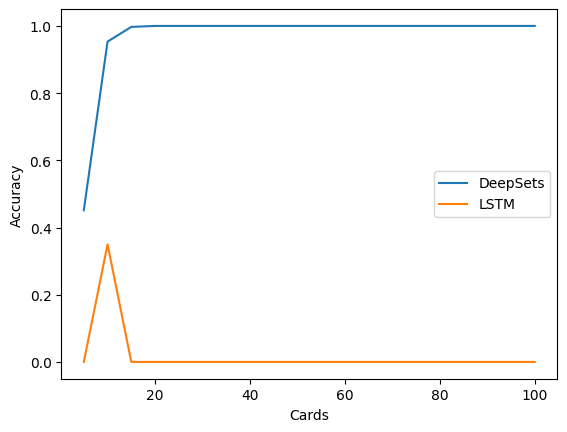

In [18]:
############## Task 7

##################
plt.plot(cards, results['deepsets']['acc'], label='DeepSets')
plt.plot(cards, results['lstm']['acc'], label='LSTM')
plt.xlabel('Cards')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
##################

# 3. Graph Generation with Variational Graph Autoencoders

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_layers, dropout=0.2):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.mlps = torch.nn.ModuleList()
        self.mlps.append(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU()
                            ))

        for layer in range(n_layers-1):
            self.mlps.append(nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU()
                            ))

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, adj, x, idx):
        ############## Task 8

        ##################
        for i in range(self.n_layers):
            x = torch.mm(adj, x)
            x = self.mlps[i](x)
        ##################

        # Readout
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1), device=x.device, requires_grad=False)
        out = out.scatter_add_(0, idx, x)

        out = self.fc(out)
        return out

In [ ]:
# Variational Autoencoder
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes):
        super(VariationalAutoEncoder, self).__init__()
        self.n_max_nodes = n_max_nodes
        self.input_dim = input_dim
        self.encoder = Encoder(input_dim, hidden_dim_enc, hidden_dim_enc, n_layers_enc)
        self.fc_mu = nn.Linear(hidden_dim_enc, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_enc, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim_dec, n_layers_dec, n_max_nodes)

    def reparameterize(self, mu, logvar, eps_scale=1.):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std) * eps_scale
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, mu):
        adj = self.decoder(mu)
        adj = torch.sigmoid(adj)
        adj = adj * (1 - torch.eye(adj.size(-2), adj.size(-1), device=adj.device))
        return adj

    def loss_function(self, adj, x, idx, y, beta=0.05):
        x_g  = self.encoder(adj, x, idx)

        ############## Task 9

        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)

        x_g = self.reparameterize(mu, logvar)
        adj = self.decoder(x_g)

        triu_idx = torch.triu_indices(self.n_max_nodes, self.n_max_nodes)
        recon = F.binary_cross_entropy_with_logits(adj[:,triu_idx[0,:],triu_idx[1,:]], y[:,triu_idx[0,:],triu_idx[1,:]], reduction='sum', pos_weight=torch.tensor(1./0.4))
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta*kld

        return loss, recon, kld

In [ ]:
#from torch_geometric.nn import global_add_pool

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, n_layers, n_nodes, dropout=0.2):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.n_nodes = n_nodes

        self.fc = nn.ModuleList()
        self.fc.append(nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim),
                            nn.Dropout(dropout)
                            ))

        for i in range(1, n_layers):
            self.fc.append(nn.Sequential(nn.Linear(hidden_dim*i, hidden_dim*(i+1)),
                            nn.ReLU(),
                            nn.LayerNorm(hidden_dim*(i+1)),
                            nn.Dropout(dropout)
                            ))

        self.fc_proj = nn.Linear(hidden_dim*n_layers, n_nodes*n_nodes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        ############## Task 10

        ##################
        for i in range(self.n_layers):
            x = self.relu(self.fc[i](x))
        x = self.fc_proj(x)
        x = x.reshape(-1, self.n_nodes, self.n_nodes)
        adj = (x + torch.transpose(x, 1, 2))/2
        ##################

        return adj

In [ ]:

import numpy as np
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
import torch

def normalize_adjacency(A):
    # Normalizes adjacency matrix represnted as a sparse SciPy matrix
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1)
    D_inv = sp.diags(inv_degs)
    A_normalized = D_inv.dot(A)
    return A_normalized

def sparse_mx_to_torch_sparse(M):
    # Converts a sparse SciPy matrix to a sparse PyTorch tensor
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def find_communities_and_plot(G):
    # Compute the best partition using Louvain algorithm
    partition = nx.community.louvain_communities(G)

    # Reorder the adjacency matrix
    ordered_nodes = list()
    for p in partition:
        for node in p:
            ordered_nodes.append(node)

    reordered_matrix = nx.to_numpy_array(G, nodelist=ordered_nodes)

    # Plot adjacency matrix
    plt.imshow(reordered_matrix, cmap='gray')
    plt.title("Reordered Adjacency Matrix")
    plt.show()

    # Draw the graph
    plt.title('Generated graph')
    nx.draw(G)
    plt.show()

<ipython-input-81-b4cf8bd965b9>:23: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


Epoch: 0005, Train Loss: 431.42792, Train Reconstruction Loss: 430.71, Train KLD Loss: 14.45, Val Loss: 433.42545, Val Reconstruction Loss: 432.75, Val KLD Loss: 13.50
Epoch: 0010, Train Loss: 365.37976, Train Reconstruction Loss: 364.13, Train KLD Loss: 24.93, Val Loss: 368.31143, Val Reconstruction Loss: 366.99, Val KLD Loss: 26.45
Epoch: 0015, Train Loss: 344.17258, Train Reconstruction Loss: 342.54, Train KLD Loss: 32.65, Val Loss: 351.13065, Val Reconstruction Loss: 349.44, Val KLD Loss: 33.86
Epoch: 0020, Train Loss: 330.73181, Train Reconstruction Loss: 328.89, Train KLD Loss: 36.74, Val Loss: 343.72159, Val Reconstruction Loss: 341.74, Val KLD Loss: 39.55
Epoch: 0025, Train Loss: 319.19592, Train Reconstruction Loss: 317.04, Train KLD Loss: 43.18, Val Loss: 321.59555, Val Reconstruction Loss: 319.39, Val KLD Loss: 44.21
Epoch: 0030, Train Loss: 311.61234, Train Reconstruction Loss: 309.30, Train KLD Loss: 46.28, Val Loss: 318.98151, Val Reconstruction Loss: 316.65, Val KLD Loss

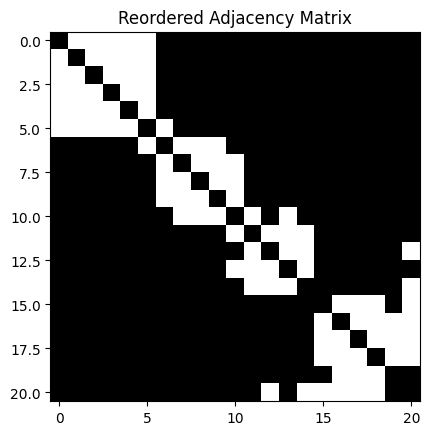

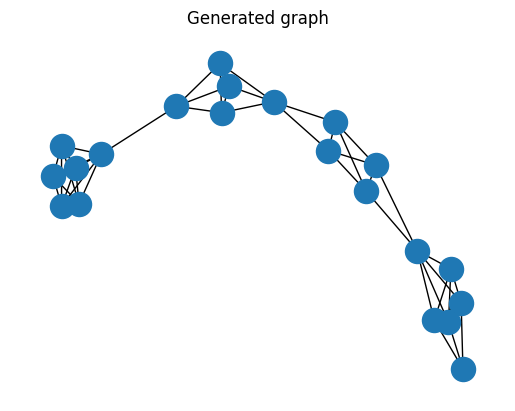

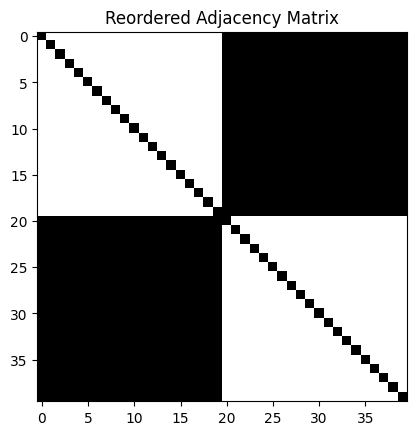

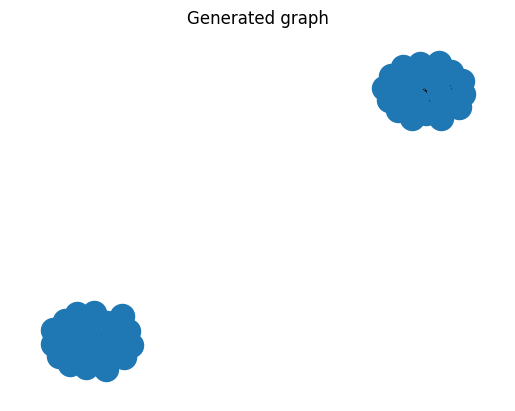

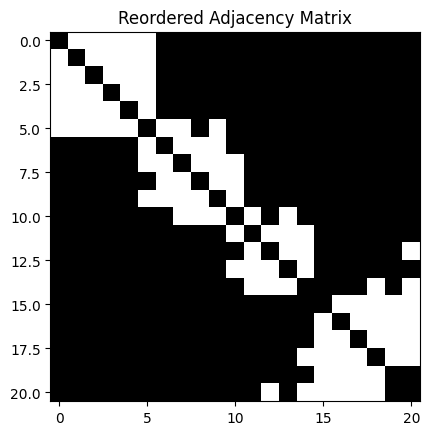

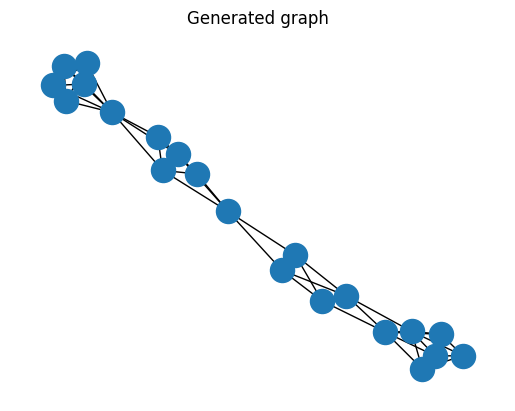

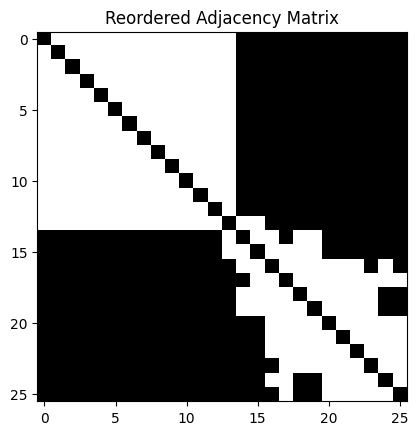

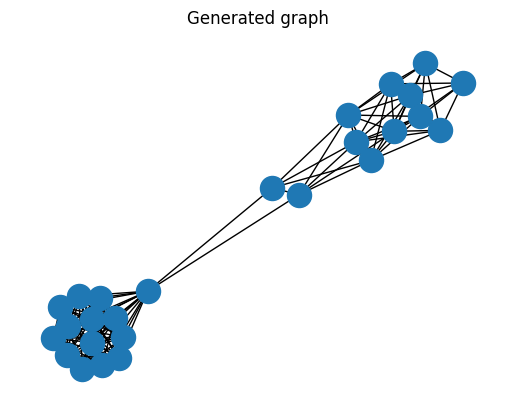

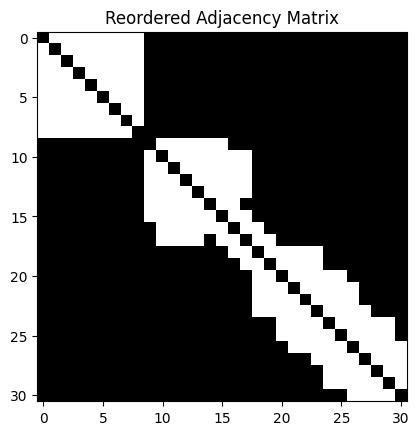

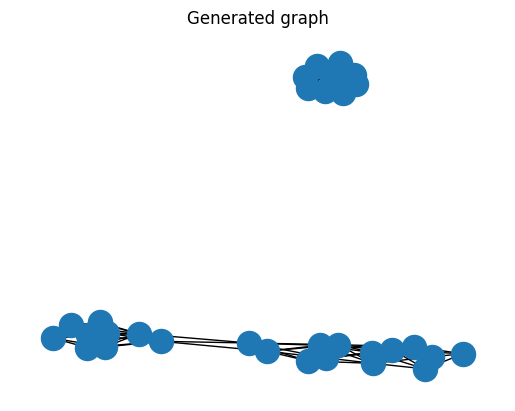

In [ ]:
np.random.seed(13)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
epochs = 100
batch_size = 32
hidden_dim_encoder = 32
n_layers_encoder = 2
latent_dim = 16
hidden_dim_decoder = 32
n_layers_decoder = 2
max_nodes = 40
input_feats = 2

# Load dataset
adj_dict = loadmat("data/sbm.mat")
adj = [adj_dict['G'+str(i)] for i in range(1000)]
n_graphs = len(adj)

# Normalize adjacency matrices
adj_normalized = [normalize_adjacency(adj[i]) for i in range(len(adj))]

# Compute node features
x = list()
for i in range(len(adj)):
    n = adj[i].shape[0]
    v = np.zeros((n,2))
    v[:,0] = adj[i].dot(np.ones(n))/max_nodes
    v[:,1] = adj[i].dot(v[:,0])/max_nodes
    x.append(v)

# Slit into training and validation sets
idx = np.random.permutation(n_graphs)
train_idx = [int(i) for i in idx[:int(0.9*idx.size)]]
val_idx = [int(i) for i in idx[int(0.9*idx.size):]]

n_train = len(train_idx)
n_val = len(val_idx)

# Initialize autoencoder
autoencoder = VariationalAutoEncoder(input_feats, hidden_dim_encoder, hidden_dim_decoder, latent_dim, n_layers_encoder, n_layers_decoder, max_nodes).to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train autoencoder
best_val_loss = np.inf
for epoch in range(1, epochs+1):
    autoencoder.train()
    train_loss_all = 0
    train_count = 0
    train_loss_all_recon = 0
    train_loss_all_kld = 0

    shuffle(train_idx)

    for i in range(0, n_train, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_train, i+batch_size)):
            n = adj[train_idx[j]].shape[0]
            adj_batch.append(adj_normalized[train_idx[j]])
            x_batch.append(x[train_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[train_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))

        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        optimizer.zero_grad()
        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        train_loss_all_recon += recon.item()
        train_loss_all_kld += kld.item()
        loss.backward()
        train_loss_all += loss.item()
        train_count += torch.max(idx_batch)+1
        optimizer.step()

    autoencoder.eval()
    val_loss_all = 0
    val_count = 0
    val_loss_all_recon = 0
    val_loss_all_kld = 0

    for i in range(0, n_val, batch_size):
        adj_batch = list()
        x_batch = list()
        idx_batch = list()
        y_batch = list()
        for j in range(i, min(n_val, i+batch_size)):
            n = adj[val_idx[j]].shape[0]
            adj_batch.append(adj_normalized[val_idx[j]])
            x_batch.append(x[val_idx[j]])
            idx_batch += [j-i]*n
            y_batch.append(np.expand_dims(np.pad(adj[val_idx[j]].todense(), ((0,max_nodes-n),(0,max_nodes-n))), axis=0))

        adj_batch = sp.block_diag(adj_batch)
        x_batch = np.vstack(x_batch)
        y_batch = np.vstack(y_batch)

        adj_batch = sparse_mx_to_torch_sparse(adj_batch).to(device)
        x_batch = torch.FloatTensor(x_batch).to(device)
        idx_batch = torch.LongTensor(idx_batch).to(device)
        y_batch = torch.FloatTensor(y_batch).to(device)

        loss, recon, kld  = autoencoder.loss_function(adj_batch, x_batch, idx_batch, y_batch)
        val_loss_all_recon += recon.item()
        val_loss_all_kld += kld.item()
        val_loss_all += loss.item()
        val_count += torch.max(idx_batch)+1

    if epoch % 5 == 0:
        print('Epoch: {:04d}, Train Loss: {:.5f}, Train Reconstruction Loss: {:.2f}, Train KLD Loss: {:.2f}, Val Loss: {:.5f}, Val Reconstruction Loss: {:.2f}, Val KLD Loss: {:.2f}'.format(epoch, train_loss_all/train_count, train_loss_all_recon/train_count, train_loss_all_kld/train_count, val_loss_all/val_count, val_loss_all_recon/val_count, val_loss_all_kld/val_count))

autoencoder.eval()


############## Task 11
z = torch.randn(5, latent_dim)
adj = autoencoder.decoder(z)


# Create and visualize graphs
for i in range(adj.size(0)):
    A = adj[i,:,:].detach().cpu().numpy()
    A[A>=0.5] = 1
    A[A<0.5] = 0
    G = nx.from_numpy_array(A)
    to_remove = list()
    for node in G.nodes():
        if G.degree(node) == 0:
            to_remove.append(node)
    G.remove_nodes_from(to_remove)
    find_communities_and_plot(G)